In [1]:
# Download utils.py from GitHub (vit branch)
!wget -q https://raw.githubusercontent.com/shaun-friedman/cv-serengeti-animal-detector/vit/utils.py -O utils.py

import os
if os.path.exists("utils.py"):
    print("✓ utils.py downloaded successfully from vit branch")
else:
    print("✗ Failed to download utils.py")

✓ utils.py downloaded successfully from vit branch


In [2]:
# Import and reload utils module
import importlib
import utils
importlib.reload(utils)
print("✓ utils module loaded successfully")

✓ utils module loaded successfully


# ViT + Custom BBox Head for Serengeti Animal Detection

This notebook implements a Vision Transformer (ViT) with custom classification and bounding box regression heads for the Serengeti wildlife dataset.

## Phase 1: Data Preparation & Exploration

### Setup and Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import (
    DATASET_BASE_PATH,
    # Data loading functions
    download_dataset,
    load_labels,
    prepare_label_data,
    # Dataset builders
    build_tf_dataset,
    split_dataset,
    # Visualization
    denormalize_bbox,
    plot_prediction,
)

# ViT-specific configuration (overrides default 128x128 for ViT's 224x224 requirement)
VIT_IMAGE_SIZE = (224, 224)
VIT_BATCH_SIZE = 16  # Smaller batch due to larger model

sns.set_theme()
print("Imports complete!")
print(f"ViT Image Size: {VIT_IMAGE_SIZE}")
print(f"ViT Batch Size: {VIT_BATCH_SIZE}")

Imports complete!
ViT Image Size: (224, 224)
ViT Batch Size: 16


### Download Dataset (if needed)

Uncomment and run the cell below if you need to download the dataset. This downloads from Kaggle and moves to `/content/dataset`.

In [4]:
# Download dataset and get the path
dataset_path = download_dataset()

# Build the correct path_base for image files
# kagglehub returns the root, images are in Set1/ subfolder
PATH_BASE = dataset_path + "/Set1/"
print(f"Dataset path base: {PATH_BASE}")

100%|██████████| 9.42G/9.42G [07:10<00:00, 23.5MB/s]  

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/silviamatoke/serengeti-dataset/versions/1
Dataset path base: /root/.cache/kagglehub/datasets/silviamatoke/serengeti-dataset/versions/1/Set1/


## Data Exploration

### Load and Inspect Raw Labels

In [5]:
# Load raw labels
labels_df = load_labels()

print(f"Dataset shape: {labels_df.shape}")
print(f"Columns: {labels_df.columns.tolist()}")
labels_df.head(10)

✓ Downloaded labels.csv to labels.csv
Dataset shape: (1277, 37)
Columns: ['file_path', 'animal', 'sequence', 'image_path', 'animal_count', 'a1', 'a2', 'a3', 'a4', 'b1', 'b2', 'b3', 'b4', 'c1', 'c2', 'c3', 'c4', 'd1', 'd2', 'd3', 'd4', 'e1', 'e2', 'e3', 'e4', 'f1', 'f2', 'f3', 'f4', 'g1', 'g2', 'g3', 'g4', 'h1', 'h2', 'h3', 'h4']


,file_path,animal,sequence,image_path,animal_count,a1,a2,a3,a4,b1,...,f3,f4,g1,g2,g3,g4,h1,h2,h3,h4
0,1.02-Agouti/SEQ75520/SEQ75520_IMG_0001.JPG,Agouti,SEQ75520,SEQ75520_IMG0001.JPG,1,1121.0,841.0,1392.0,1051.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.02-Agouti/SEQ75520/SEQ75520_IMG_0002.JPG,Agouti,SEQ75520,SEQ75520_IMG0002.JPG,1,1227.0,825.0,1537.0,1054.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.02-Agouti/SEQ75520/SEQ75520_IMG_0003.JPG,Agouti,SEQ75520,SEQ75520_IMG0003.JPG,1,1401.0,788.0,1734.0,1027.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.02-Agouti/SEQ75520/SEQ75520_IMG_0004.JPG,Agouti,SEQ75520,SEQ75520_IMG0004.JPG,1,1619.0,757.0,1916.0,984.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.02-Agouti/SEQ75520/SEQ75520_IMG_0005.JPG,Agouti,SEQ75520,SEQ75520_IMG0005.JPG,1,1780.0,714.0,1918.0,918.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.02-Agouti/SEQ75520/SEQ75520_IMG_0006.JPG,Agouti,SEQ75520,SEQ75520_IMG0006.JPG,1,1828.0,719.0,1918.0,909.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1.02-Agouti/SEQ75520/SEQ75520_IMG_0007.JPG,Agouti,SEQ75520,SEQ75520_IMG0007.JPG,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.02-Agouti/SEQ75520/SEQ75520_IMG_0008.JPG,Agouti,SEQ75520,SEQ75520_IMG0008.JPG,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.02-Agouti/SEQ75520/SEQ75520_IMG_0009.JPG,Agouti,SEQ75520,SEQ75520_IMG0009.JPG,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.02-Agouti/SEQ75520/SEQ75520_IMG_0010.JPG,Agouti,SEQ75520,SEQ75520_IMG0010.JPG,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Check for Missing Values

Let's check if there are any missing values, especially in the bounding box columns (`a1`, `a2`, `a3`, `a4`) and `animal_count`.

In [ ]:
# Check missing values across all columns
print("Missing values per column:")
print(labels_df.isnull().sum())
print(f"\nTotal rows: {len(labels_df)}")

Missing values per column:
file_path          0
animal             0
sequence           0
image_path         0
animal_count       0
a1               330
a2               330
a3               330
a4               330
b1              1189
b2              1189
b3              1189
b4              1189
c1              1246
c2              1246
c3              1246
c4              1246
d1              1258
d2              1258
d3              1258
d4              1258
e1              1261
e2              1261
e3              1261
e4              1261
f1              1271
f2              1271
f3              1271
f4              1271
g1              1276
g2              1276
g3              1276
g4              1276
h1              1276
h2              1276
h3              1276
h4              1276
dtype: int64

Total rows: 1277


In [7]:
# Check animal_count distribution
print("Animal count distribution:")
print(labels_df["animal_count"].value_counts().sort_index())

# How many rows have animals (animal_count > 0)?
has_animals = labels_df[labels_df["animal_count"] > 0]
no_animals = labels_df[labels_df["animal_count"] == 0]

print(f"\nRows with animals (animal_count > 0): {len(has_animals)}")
print(f"Rows without animals (animal_count = 0): {len(no_animals)}")

Animal count distribution:
animal_count
0    330
1    859
2     57
3     12
4      3
5     10
6      5
8      1
Name: count, dtype: int64

Rows with animals (animal_count > 0): 947
Rows without animals (animal_count = 0): 330


In [ ]:
# Check bounding box columns for rows WITH animals
bbox_cols = ["a1", "a2", "a3", "a4"]

print("Bounding box analysis for rows WITH animals (animal_count > 0):")
print("-" * 50)

# Check for NaN values in bbox columns
bbox_nulls = has_animals[bbox_cols].isnull().sum()
print(f"NaN values in bbox columns:\n{bbox_nulls}")

# Check for zero values in bbox columns (might indicate missing data)
bbox_zeros = (has_animals[bbox_cols] == 0).all(axis=1).sum()
print(f"\nRows where ALL bbox values are 0: {bbox_zeros}")

# Check for any invalid bboxes (all zeros or any NaN)
invalid_bbox_mask = has_animals[bbox_cols].isnull().any(axis=1) | (has_animals[bbox_cols] == 0).all(axis=1)
invalid_count = invalid_bbox_mask.sum()
valid_count = len(has_animals) - invalid_count

print(f"\nValid bounding boxes: {valid_count}")
print(f"Invalid bounding boxes: {invalid_count}")

Bounding box analysis for rows WITH animals (animal_count > 0):
--------------------------------------------------
NaN values in bbox columns:
a1    0
a2    0
a3    0
a4    0
dtype: int64

Rows where ALL bbox values are 0: 0

Valid bounding boxes: 947
Invalid bounding boxes: 0


### Prepare Filtered Data

Now let's use `prepare_label_data()` to filter for images with animals and prepare the data for training.

In [9]:
# Prepare label data using utils function with correct path base
filepaths, labels, bbox_array, label_encoder, positives = prepare_label_data(
    labels_df, path_base=PATH_BASE
)

print(f"Filtered dataset size: {len(filepaths)}")
print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")

Filtered dataset size: 947
Number of classes: 19
Classes: ['Agouti' 'Bird_spec' 'Coiban_Agouti' 'Collared_Peccary' 'Common_Opossum'
 'European_Hare' 'Great_Tinamou' 'Mouflon' 'Ocelot' 'Paca' 'Red_Deer'
 'Red_Fox' 'Red_Squirrel' 'Roe_Deer' 'Spiny_Rat' 'White-nosed_Coati'
 'White_Tailed_Deer' 'Wild_Boar' 'Wood_Mouse']


### Clean Corrupted Images

Scan for and remove corrupted/truncated image files before training.

In [24]:
from PIL import Image, ImageFile
from tqdm import tqdm

def find_corrupted_images(filepaths):
    """
    Scan all image files and identify corrupted/truncated ones.
    Returns list of indices of valid images and corrupted images.
    """
    corrupted_indices = []
    valid_indices = []
    
    print("Scanning for corrupted images...")
    for idx, filepath in enumerate(tqdm(filepaths)):
        try:
            # Try to fully load and verify the image
            with Image.open(filepath) as img:
                img.verify()  # Verify it's a valid image
            
            # Re-open and try to load pixels (verify doesn't catch all issues)
            with Image.open(filepath) as img:
                img.load()  # Actually load the image data
            
            valid_indices.append(idx)
        except Exception as e:
            corrupted_indices.append(idx)
            print(f"  ✗ Corrupted: {filepath}")
            print(f"    Error: {e}")
    
    return valid_indices, corrupted_indices

# Find corrupted images
valid_indices, corrupted_indices = find_corrupted_images(filepaths)

print(f"\n{'='*60}")
print(f"IMAGE VALIDATION RESULTS")
print(f"{'='*60}")
print(f"Total images scanned: {len(filepaths)}")
print(f"Valid images: {len(valid_indices)}")
print(f"Corrupted images: {len(corrupted_indices)}")

if len(corrupted_indices) > 0:
    print(f"\nRemoving {len(corrupted_indices)} corrupted images from dataset...")
    
    # Filter out corrupted images
    filepaths = filepaths[valid_indices]
    labels = labels[valid_indices]
    bbox_array = bbox_array[valid_indices]
    
    print(f"✓ Dataset cleaned! New size: {len(filepaths)} images")
else:
    print(f"\n✓ All images are valid!")

print(f"{'='*60}")

Scanning for corrupted images...


Scanning for corrupted images...


100%|██████████| 946/946 [00:13<00:00, 70.00it/s]

Scanning for corrupted images...


100%|██████████| 946/946 [00:13<00:00, 70.00it/s]


IMAGE VALIDATION RESULTS
Total images scanned: 946
Valid images: 946
Corrupted images: 0

✓ All images are valid!


In [ ]:
# Verify bounding boxes in prepared data
print("Bounding box array shape:", bbox_array.shape)
print("Bounding box dtype:", bbox_array.dtype)

# Check for NaN or invalid values
nan_count = np.isnan(bbox_array).any(axis=1).sum()
all_zeros_count = (bbox_array == 0).all(axis=1).sum()

print(f"\nRows with NaN in bbox: {nan_count}")
print(f"Rows with all-zero bbox: {all_zeros_count}")

# Bbox statistics
print("\nBounding box statistics:")
print(f"  Min values: {bbox_array.min(axis=0)}")
print(f"  Max values: {bbox_array.max(axis=0)}")
print(f"  Mean values: {bbox_array.mean(axis=0).round(2)}")

Bounding box array shape: (947, 4)
Bounding box dtype: float32

Rows with NaN in bbox: 0
Rows with all-zero bbox: 0

Bounding box statistics:
  Min values: [  1.  21.  87. 243.]
  Max values: [1978. 1424. 2048. 1521.]
  Mean values: [ 858.13  637.46 1283.4   990.56]


### Class Distribution

Let's visualize the distribution of animal classes in our dataset.

Class distribution:
Red_Deer             131
Agouti                87
Collared_Peccary      82
Ocelot                63
Paca                  57
Wild_Boar             56
White_Tailed_Deer     47
Roe_Deer              46
Mouflon               45
Great_Tinamou         44
Common_Opossum        44
Red_Squirrel          39
White-nosed_Coati     38
Spiny_Rat             34
Bird_spec             29
Wood_Mouse            29
European_Hare         28
Red_Fox               25
Coiban_Agouti         23
Name: count, dtype: int64


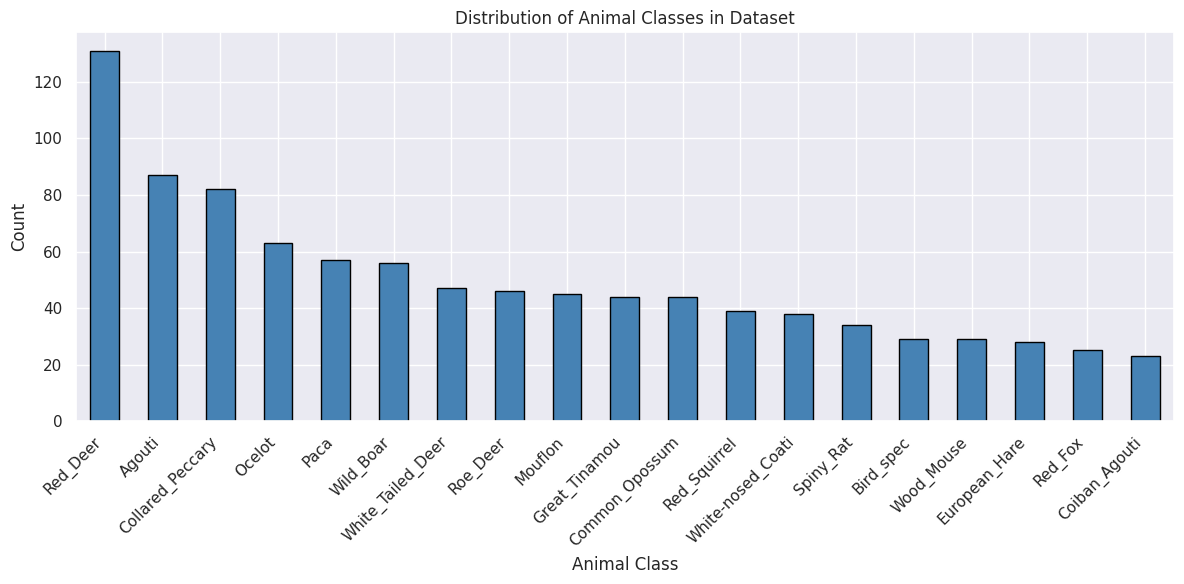


Most common class: Red_Deer (131 samples)
Least common class: Coiban_Agouti (23 samples)
Imbalance ratio: 5.70x


In [11]:
# Class distribution
class_names = label_encoder.inverse_transform(labels)
class_counts = pd.Series(class_names).value_counts()

print("Class distribution:")
print(class_counts)

# Plot class distribution
fig, ax = plt.subplots(figsize=(12, 6))
class_counts.plot(kind="bar", ax=ax, color="steelblue", edgecolor="black")
ax.set_xlabel("Animal Class")
ax.set_ylabel("Count")
ax.set_title("Distribution of Animal Classes in Dataset")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Check for class imbalance
print(f"\nMost common class: {class_counts.idxmax()} ({class_counts.max()} samples)")
print(f"Least common class: {class_counts.idxmin()} ({class_counts.min()} samples)")
print(f"Imbalance ratio: {class_counts.max() / class_counts.min():.2f}x")

### Visualize Sample Images with Bounding Boxes

Let's look at some sample images with their annotated bounding boxes to understand the data quality.

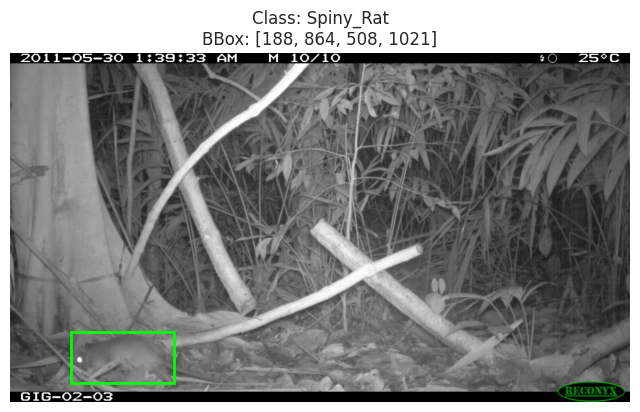

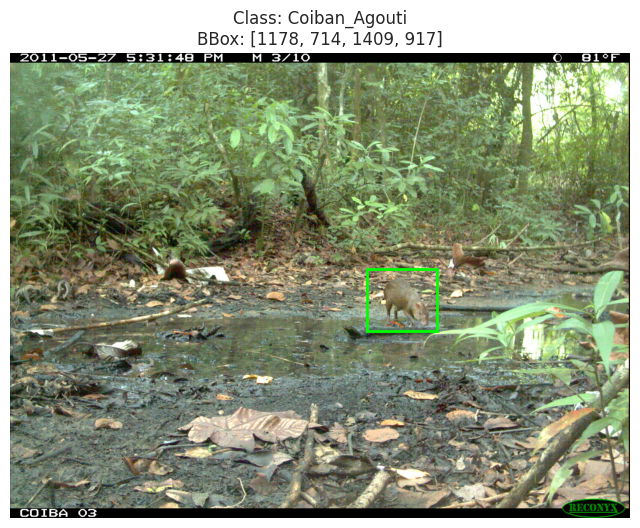

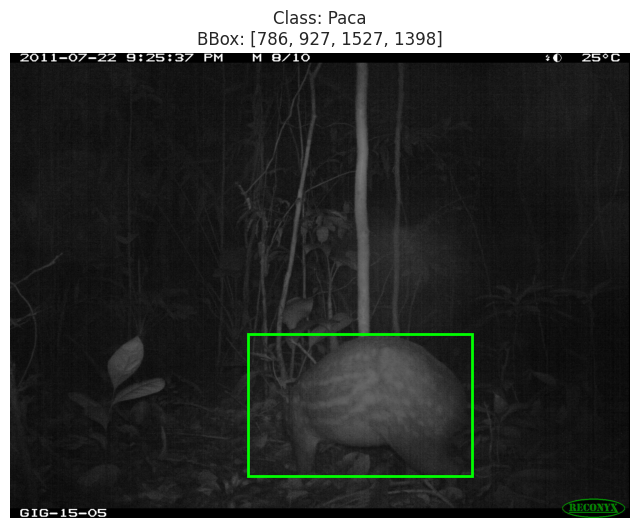

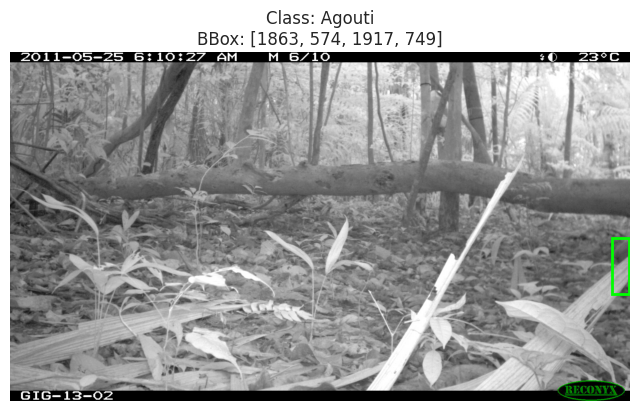

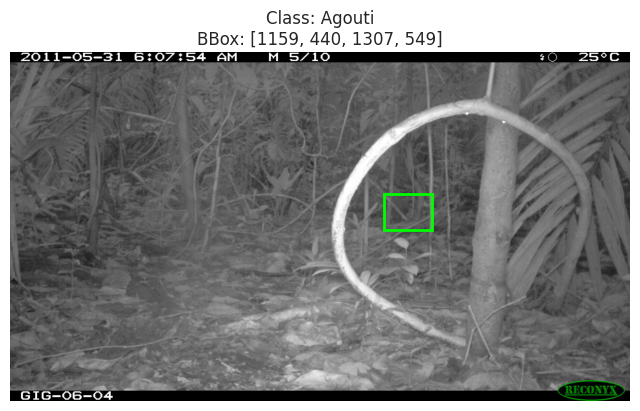

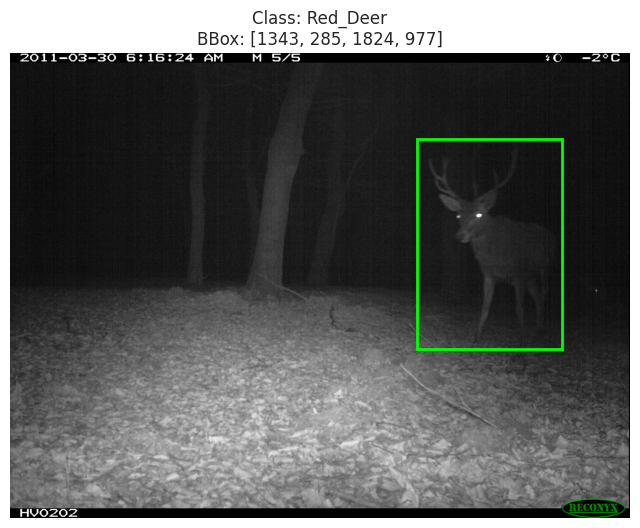

In [12]:
import matplotlib.patches as patches
from PIL import Image

def visualize_sample(idx, filepaths, labels, bbox_array, label_encoder):
    """Visualize a single sample with its bounding box."""
    filepath = filepaths[idx]
    label = labels[idx]
    bbox = bbox_array[idx]
    class_name = label_encoder.inverse_transform([label])[0]
    
    try:
        # Load image
        img = Image.open(filepath)
        img_width, img_height = img.size
        
        # Create figure
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(img)
        
        # Draw bounding box (bbox is [x1, y1, x2, y2] in pixel coordinates)
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='lime', facecolor='none'
        )
        ax.add_patch(rect)
        
        ax.set_title(f"Class: {class_name}\nBBox: [{x1:.0f}, {y1:.0f}, {x2:.0f}, {y2:.0f}]")
        ax.axis('off')
        plt.show()
        
    except Exception as e:
        print(f"Error loading image {filepath}: {e}")

# Visualize a few random samples
np.random.seed(42)
sample_indices = np.random.choice(len(filepaths), size=6, replace=False)

for idx in sample_indices:
    visualize_sample(idx, filepaths, labels, bbox_array, label_encoder)

## Build TensorFlow Datasets

Now let's build the TensorFlow datasets and create train/validation/test splits.

In [25]:
# Build TensorFlow dataset with ViT-specific image size
ds = build_tf_dataset(filepaths, labels, bbox_array, image_size=VIT_IMAGE_SIZE)

print(f"Dataset created successfully")
print(f"Image size: {VIT_IMAGE_SIZE}")
print(f"Batch size: {VIT_BATCH_SIZE}")

Dataset created successfully
Image size: (224, 224)
Batch size: 16


In [26]:
# Split into train/val/test with ViT-specific batch size
total_size = len(filepaths)  # Use filepaths length (accounts for cleaned corrupted images)
splits = split_dataset(ds, total_size=total_size, batch_size=VIT_BATCH_SIZE)

train_ds = splits["train"]
val_ds = splits["val"]
test_ds = splits["test"]

# Calculate split sizes
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

print(f"Dataset splits (80/10/10):")
print(f"  Training:   {train_size} samples")
print(f"  Validation: {val_size} samples")
print(f"  Test:       {test_size} samples")
print(f"  Total:      {total_size} samples")

Dataset splits (80/10/10):
  Training:   756 samples
  Validation: 94 samples
  Test:       96 samples
  Total:      946 samples


In [27]:
# Verify dataset by inspecting a batch
for batch_images, batch_labels in train_ds.take(1):
    print("Sample batch inspection:")
    print(f"  Image batch shape: {batch_images.shape}")
    print(f"  Image dtype: {batch_images.dtype}")
    print(f"  Image value range: [{batch_images.numpy().min():.3f}, {batch_images.numpy().max():.3f}]")
    print(f"  Class labels shape: {batch_labels['class_output'].shape}")
    print(f"  Bbox output shape: {batch_labels['bbox_output'].shape}")
    print(f"  Sample class labels: {batch_labels['class_output'].numpy()[:5]}")
    print(f"  Sample bbox (normalized): {batch_labels['bbox_output'].numpy()[0]}")

Sample batch inspection:
  Image batch shape: (16, 224, 224, 3)
  Image dtype: <dtype: 'float32'>
  Image value range: [0.000, 255.000]
  Class labels shape: (16,)
  Bbox output shape: (16, 4)
  Sample class labels: [ 0  0  8  9 10]
  Sample bbox (normalized): [0.7296875  0.72962964 0.903125   0.95092595]


## Data Summary

Summary of the prepared dataset for ViT training.

In [28]:
# Final summary
print("=" * 60)
print("PHASE 1 COMPLETE: Data Preparation Summary")
print("=" * 60)
print(f"\nDataset Statistics:")
print(f"  Total samples (with animals): {total_size}")
print(f"  Number of classes: {len(label_encoder.classes_)}")
print(f"  Classes: {list(label_encoder.classes_)}")
print(f"\nImage Configuration:")
print(f"  Image size: {VIT_IMAGE_SIZE}")
print(f"  Batch size: {VIT_BATCH_SIZE}")
print(f"\nData Splits:")
print(f"  Training:   {train_size} samples ({train_size/total_size*100:.1f}%)")
print(f"  Validation: {val_size} samples ({val_size/total_size*100:.1f}%)")
print(f"  Test:       {test_size} samples ({test_size/total_size*100:.1f}%)")
print(f"\nBounding Box Info:")
print(f"  Format: [x1, y1, x2, y2] (normalized 0-1 after preprocessing)")
print(f"  All samples have valid bounding boxes: {nan_count == 0 and all_zeros_count == 0}")
print("=" * 60)

PHASE 1 COMPLETE: Data Preparation Summary

Dataset Statistics:
  Total samples (with animals): 946
  Number of classes: 19
  Classes: ['Agouti', 'Bird_spec', 'Coiban_Agouti', 'Collared_Peccary', 'Common_Opossum', 'European_Hare', 'Great_Tinamou', 'Mouflon', 'Ocelot', 'Paca', 'Red_Deer', 'Red_Fox', 'Red_Squirrel', 'Roe_Deer', 'Spiny_Rat', 'White-nosed_Coati', 'White_Tailed_Deer', 'Wild_Boar', 'Wood_Mouse']

Image Configuration:
  Image size: (224, 224)
  Batch size: 16

Data Splits:
  Training:   756 samples (79.9%)
  Validation: 94 samples (9.9%)
  Test:       96 samples (10.1%)

Bounding Box Info:
  Format: [x1, y1, x2, y2] (normalized 0-1 after preprocessing)
  All samples have valid bounding boxes: True


---

## Phase 2: ViT Model Implementation

Now we'll implement a Vision Transformer (ViT) with custom classification and bounding box regression heads.

**Configuration:** This notebook uses `VIT_IMAGE_SIZE = (224, 224)` and `VIT_BATCH_SIZE = 16`, passed as parameters to `utils.py` functions. The default `IMAGE_SIZE` in utils.py remains 128×128 for the CNN notebook.

In [42]:
# Install required packages for PyTorch ViT
!pip install -q transformers torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTModel
from PIL import Image
from tqdm import tqdm

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ Device: {device}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")

✓ PyTorch version: 2.9.0+cu126
✓ Device: cuda
✓ GPU: Tesla T4


### PyTorch Dataset Class

Create a custom Dataset class to load images and labels for PyTorch DataLoaders.

In [43]:
from sklearn.model_selection import train_test_split
from PIL import ImageFile

# Allow loading truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# ==============================================================================
# PART 1: PYTORCH DATASET AND MODEL SETUP
# ==============================================================================

# --- Custom Dataset Class ---
class SerengetiDataset(Dataset):
    """PyTorch Dataset for Serengeti wildlife images with bounding boxes."""
    
    def __init__(self, filepaths, labels, bboxes, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.bboxes = bboxes  # Raw pixel coordinates
        self.transform = transform
    
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        # Load image and get ORIGINAL dimensions before any transform
        try:
            img = Image.open(self.filepaths[idx]).convert('RGB')
            orig_w, orig_h = img.size  # Original dimensions for bbox normalization
        except Exception as e:
            # If image fails, return a black image as fallback
            print(f"Warning: Failed to load {self.filepaths[idx]}: {e}")
            img = Image.new('RGB', VIT_IMAGE_SIZE, (0, 0, 0))
            orig_w, orig_h = VIT_IMAGE_SIZE
        
        if self.transform:
            img = self.transform(img)
        
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        # NORMALIZE BBOX: Convert from raw pixel coords to 0-1 range
        # bbox format: [x1, y1, x2, y2] in original image coordinates
        raw_bbox = self.bboxes[idx].astype(np.float32)
        bbox_norm = raw_bbox / np.array([orig_w, orig_h, orig_w, orig_h], dtype=np.float32)
        # Clamp to [0, 1] to handle any edge cases
        bbox_norm = np.clip(bbox_norm, 0.0, 1.0)
        bbox = torch.tensor(bbox_norm, dtype=torch.float32)
        
        return img, label, bbox

# --- Data Transforms ---
# NOTE: Removed RandomHorizontalFlip and RandomRotation because they shift pixels
# but don't adjust bounding box coordinates, causing label misalignment.
# For bbox-aware augmentation, consider using albumentations library.
train_transform = transforms.Compose([
    transforms.Resize(VIT_IMAGE_SIZE),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(VIT_IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Split Data: 70% train, 15% val, 15% test ---
train_files, temp_files, train_labels, temp_labels, train_bboxes, temp_bboxes = train_test_split(
    filepaths, labels, bbox_array, test_size=0.3, random_state=42, stratify=labels
)

val_files, test_files, val_labels, test_labels, val_bboxes, test_bboxes = train_test_split(
    temp_files, temp_labels, temp_bboxes, test_size=0.5, random_state=42, stratify=temp_labels
)

# --- Create Datasets ---
train_dataset = SerengetiDataset(train_files, train_labels, train_bboxes, transform=train_transform)
val_dataset = SerengetiDataset(val_files, val_labels, val_bboxes, transform=val_transform)
test_dataset = SerengetiDataset(test_files, test_labels, test_bboxes, transform=val_transform)

# --- Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=VIT_BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=VIT_BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=VIT_BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✓ Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
print(f"✓ Batches - Train: {len(train_loader)} | Val: {len(val_loader)} | Test: {len(test_loader)}")

# Verify bbox normalization on first sample
sample_img, sample_label, sample_bbox = train_dataset[0]
print(f"\n✓ BBox Normalization Check:")
print(f"  Sample bbox (normalized): {sample_bbox.numpy()}")
print(f"  All values in [0,1] range: {(sample_bbox >= 0).all() and (sample_bbox <= 1).all()}")

✓ Train: 662 | Val: 142 | Test: 142
✓ Batches - Train: 42 | Val: 9 | Test: 9

✓ BBox Normalization Check:
  Sample bbox (normalized): [0.34427083 0.47777778 0.41927084 0.7546296 ]
  All values in [0,1] range: True


### ViT Model Definition

Build a ViT model with dual heads:
- **Classification Head**: For animal species classification
- **BBox Regression Head**: For bounding box prediction

In [44]:
# Number of classes
NUM_CLASSES = len(label_encoder.classes_)
print(f"Number of classes: {NUM_CLASSES}")
print(f"Image size: {VIT_IMAGE_SIZE}")

class ViTDetector(nn.Module):
    """
    ViT model with custom classification and bounding box regression heads.
    Uses HuggingFace's pretrained ViT as backbone.
    """
    
    def __init__(self, num_classes, trainable_backbone=False):
        super().__init__()
        
        # Load pretrained ViT backbone
        print("Loading ViT from Hugging Face transformers...")
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        
        # Freeze backbone if not fine-tuning
        for param in self.vit.parameters():
            param.requires_grad = trainable_backbone
        
        # ViT-Base hidden size is 768
        hidden_size = self.vit.config.hidden_size
        
        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
        
        # Bounding Box Regression Head
        self.bbox_head = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 4),
            nn.Sigmoid()  # Normalize bbox to [0, 1]
        )
    
    def forward(self, pixel_values):
        # Pass through ViT backbone
        outputs = self.vit(pixel_values=pixel_values)
        
        # Get CLS token (first token of last hidden state)
        cls_token = outputs.last_hidden_state[:, 0, :]  # Shape: (batch, 768)
        
        # Get predictions from both heads
        class_logits = self.classifier(cls_token)
        bbox_pred = self.bbox_head(cls_token)
        
        return class_logits, bbox_pred

# --- Build Model ---
model = ViTDetector(NUM_CLASSES, trainable_backbone=False)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n" + "=" * 60)
print("MODEL BUILT SUCCESSFULLY")
print("=" * 60)
print(f"Device: {device}")
print(f"Backbone: ViT-Base-Patch16-224 (frozen)")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Classification head: Linear(768→256→128→{NUM_CLASSES})")
print(f"BBox head: Linear(768→256→128→4)")
print("=" * 60)

Number of classes: 19
Image size: (224, 224)
Loading ViT from Hugging Face transformers...

MODEL BUILT SUCCESSFULLY
Device: cuda
Backbone: ViT-Base-Patch16-224 (frozen)
Total parameters: 86,851,735
Trainable parameters: 462,487
Classification head: Linear(768→256→128→19)
BBox head: Linear(768→256→128→4)

MODEL BUILT SUCCESSFULLY
Device: cuda
Backbone: ViT-Base-Patch16-224 (frozen)
Total parameters: 86,851,735
Trainable parameters: 462,487
Classification head: Linear(768→256→128→19)
BBox head: Linear(768→256→128→4)


## Part 2: Training

Training loop with:
- CrossEntropyLoss for classification
- MSELoss for bounding box regression
- AdamW optimizer with learning rate scheduling
- Early stopping

In [45]:
# ==============================================================================
# PART 2: TRAINING
# ==============================================================================

# --- Training Configuration ---
EPOCHS = 50
LEARNING_RATE = 1e-4
PATIENCE = 10  # Early stopping patience

# --- Loss Functions ---
criterion_class = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()

# --- Optimizer ---
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

# --- Learning Rate Scheduler ---
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

print("Training Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Optimizer: AdamW (weight_decay=0.01)")
print(f"  Early stopping patience: {PATIENCE}")
print(f"  LR scheduler: ReduceLROnPlateau")

Training Configuration:
  Epochs: 50
  Learning rate: 0.0001
  Optimizer: AdamW (weight_decay=0.01)
  Early stopping patience: 10
  LR scheduler: ReduceLROnPlateau


### Training Loop

Execute the training with validation at each epoch.

In [46]:
def train_one_epoch(model, loader, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    total_class_loss = 0
    total_bbox_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc="Training")
    for images, labels, bboxes in pbar:
        images = images.to(device)
        labels = labels.to(device)
        bboxes = bboxes.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        class_logits, bbox_pred = model(images)
        
        # Compute losses
        class_loss = criterion_class(class_logits, labels)
        bbox_loss = criterion_bbox(bbox_pred, bboxes)
        loss = class_loss + bbox_loss
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item()
        total_class_loss += class_loss.item()
        total_bbox_loss += bbox_loss.item()
        
        _, predicted = class_logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.*correct/total:.1f}%'
        })
    
    n_batches = len(loader)
    return {
        'loss': total_loss / n_batches,
        'class_loss': total_class_loss / n_batches,
        'bbox_loss': total_bbox_loss / n_batches,
        'accuracy': 100. * correct / total
    }


def validate(model, loader, device):
    """Validate the model."""
    model.eval()
    total_loss = 0
    total_class_loss = 0
    total_bbox_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels, bboxes in loader:
            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)
            
            # Forward pass
            class_logits, bbox_pred = model(images)
            
            # Compute losses
            class_loss = criterion_class(class_logits, labels)
            bbox_loss = criterion_bbox(bbox_pred, bboxes)
            loss = class_loss + bbox_loss
            
            # Track metrics
            total_loss += loss.item()
            total_class_loss += class_loss.item()
            total_bbox_loss += bbox_loss.item()
            
            _, predicted = class_logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    n_batches = len(loader)
    return {
        'loss': total_loss / n_batches,
        'class_loss': total_class_loss / n_batches,
        'bbox_loss': total_bbox_loss / n_batches,
        'accuracy': 100. * correct / total
    }


# --- Training Loop ---
print(f"Starting training on {device}...")
print("-" * 60)

best_val_loss = float('inf')
patience_counter = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    # Train
    train_metrics = train_one_epoch(model, train_loader, optimizer, device)
    
    # Validate
    val_metrics = validate(model, val_loader, device)
    
    # Update learning rate
    scheduler.step(val_metrics['loss'])
    
    # Track history
    history['train_loss'].append(train_metrics['loss'])
    history['train_acc'].append(train_metrics['accuracy'])
    history['val_loss'].append(val_metrics['loss'])
    history['val_acc'].append(val_metrics['accuracy'])
    
    # Print metrics
    print(f"  Train Loss: {train_metrics['loss']:.4f} | Train Acc: {train_metrics['accuracy']:.2f}%")
    print(f"  Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['accuracy']:.2f}%")
    
    # Early stopping check
    if val_metrics['loss'] < best_val_loss:
        best_val_loss = val_metrics['loss']
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'vit_best_model.pt')
        print(f"  ✓ New best model saved!")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\n✓ Early stopping triggered after {epoch+1} epochs")
            break

print("\n" + "=" * 60)
print("TRAINING COMPLETE")
print("=" * 60)
print(f"Best validation loss: {best_val_loss:.4f}")

# Load best model
model.load_state_dict(torch.load('vit_best_model.pt'))
print("✓ Best model weights restored")

Starting training on cuda...
------------------------------------------------------------

Epoch 1/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s, loss=3.0125, acc=9.5%]



  Train Loss: 2.9877 | Train Acc: 9.52%
  Val Loss: 2.9490 | Val Acc: 19.01%
  ✓ New best model saved!

Epoch 2/50
  ✓ New best model saved!

Epoch 2/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s, loss=2.7421, acc=24.0%]



  Train Loss: 2.9054 | Train Acc: 24.02%
  Val Loss: 2.8573 | Val Acc: 29.58%
  ✓ New best model saved!

Epoch 3/50
  ✓ New best model saved!

Epoch 3/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s, loss=2.6545, acc=25.8%]



  Train Loss: 2.7832 | Train Acc: 25.83%
  Val Loss: 2.7118 | Val Acc: 26.76%
  ✓ New best model saved!

Epoch 4/50
  ✓ New best model saved!

Epoch 4/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.55it/s, loss=2.2494, acc=28.2%]



  Train Loss: 2.6127 | Train Acc: 28.25%
  Val Loss: 2.5312 | Val Acc: 28.87%
  ✓ New best model saved!

Epoch 5/50
  ✓ New best model saved!

Epoch 5/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.55it/s, loss=2.6908, acc=30.8%]



  Train Loss: 2.4180 | Train Acc: 30.82%
  Val Loss: 2.3252 | Val Acc: 32.39%
  ✓ New best model saved!

Epoch 6/50
  ✓ New best model saved!

Epoch 6/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.55it/s, loss=2.3351, acc=39.3%]



  Train Loss: 2.1990 | Train Acc: 39.27%
  Val Loss: 2.1210 | Val Acc: 42.96%
  ✓ New best model saved!

Epoch 7/50
  ✓ New best model saved!

Epoch 7/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s, loss=2.0922, acc=47.6%]



  Train Loss: 2.0029 | Train Acc: 47.58%
  Val Loss: 1.9161 | Val Acc: 47.18%
  ✓ New best model saved!

Epoch 8/50
  ✓ New best model saved!

Epoch 8/50


Training: 100%|██████████| 42/42 [00:28<00:00,  1.48it/s, loss=2.2237, acc=55.4%]



  Train Loss: 1.8085 | Train Acc: 55.44%
  Val Loss: 1.7185 | Val Acc: 64.08%
  ✓ New best model saved!

Epoch 9/50
  ✓ New best model saved!

Epoch 9/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s, loss=1.8687, acc=62.8%]



  Train Loss: 1.6130 | Train Acc: 62.84%
  Val Loss: 1.5432 | Val Acc: 66.90%
  ✓ New best model saved!

Epoch 10/50
  ✓ New best model saved!

Epoch 10/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.54it/s, loss=1.0471, acc=67.2%]



  Train Loss: 1.4512 | Train Acc: 67.22%
  Val Loss: 1.3826 | Val Acc: 73.24%
  ✓ New best model saved!

Epoch 11/50
  ✓ New best model saved!

Epoch 11/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.55it/s, loss=1.7299, acc=71.3%]



  Train Loss: 1.3221 | Train Acc: 71.30%
  Val Loss: 1.2435 | Val Acc: 76.06%
  ✓ New best model saved!

Epoch 12/50
  ✓ New best model saved!

Epoch 12/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.55it/s, loss=1.5406, acc=74.9%]



  Train Loss: 1.1970 | Train Acc: 74.92%
  Val Loss: 1.1246 | Val Acc: 77.46%
  ✓ New best model saved!

Epoch 13/50
  ✓ New best model saved!

Epoch 13/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.54it/s, loss=1.0188, acc=77.6%]



  Train Loss: 1.0651 | Train Acc: 77.64%
  Val Loss: 1.0173 | Val Acc: 81.69%
  ✓ New best model saved!

Epoch 14/50
  ✓ New best model saved!

Epoch 14/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.54it/s, loss=0.6139, acc=80.4%]



  Train Loss: 0.9927 | Train Acc: 80.36%
  Val Loss: 0.9272 | Val Acc: 83.10%
  ✓ New best model saved!

Epoch 15/50
  ✓ New best model saved!

Epoch 15/50


Training: 100%|██████████| 42/42 [00:26<00:00,  1.57it/s, loss=0.9233, acc=81.1%]



  Train Loss: 0.9049 | Train Acc: 81.12%
  Val Loss: 0.8498 | Val Acc: 85.21%
  ✓ New best model saved!

Epoch 16/50
  ✓ New best model saved!

Epoch 16/50


Training: 100%|██████████| 42/42 [00:26<00:00,  1.56it/s, loss=0.7258, acc=83.2%]



  Train Loss: 0.8179 | Train Acc: 83.23%
  Val Loss: 0.7839 | Val Acc: 85.92%
  ✓ New best model saved!

Epoch 17/50
  ✓ New best model saved!

Epoch 17/50


Training: 100%|██████████| 42/42 [00:26<00:00,  1.57it/s, loss=0.5497, acc=83.4%]



  Train Loss: 0.7794 | Train Acc: 83.38%
  Val Loss: 0.7215 | Val Acc: 85.21%
  ✓ New best model saved!

Epoch 18/50
  ✓ New best model saved!

Epoch 18/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s, loss=1.0170, acc=85.6%]



  Train Loss: 0.7148 | Train Acc: 85.65%
  Val Loss: 0.6739 | Val Acc: 85.92%
  ✓ New best model saved!

Epoch 19/50
  ✓ New best model saved!

Epoch 19/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s, loss=1.2301, acc=85.3%]



  Train Loss: 0.6759 | Train Acc: 85.35%
  Val Loss: 0.6287 | Val Acc: 87.32%
  ✓ New best model saved!

Epoch 20/50
  ✓ New best model saved!

Epoch 20/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.55it/s, loss=0.2871, acc=86.0%]



  Train Loss: 0.6279 | Train Acc: 85.95%
  Val Loss: 0.5910 | Val Acc: 88.73%
  ✓ New best model saved!

Epoch 21/50
  ✓ New best model saved!

Epoch 21/50


Training: 100%|██████████| 42/42 [00:26<00:00,  1.57it/s, loss=0.3180, acc=86.7%]



  Train Loss: 0.5953 | Train Acc: 86.71%
  Val Loss: 0.5582 | Val Acc: 88.03%
  ✓ New best model saved!

Epoch 22/50
  ✓ New best model saved!

Epoch 22/50


Training: 100%|██████████| 42/42 [00:26<00:00,  1.57it/s, loss=0.5708, acc=86.4%]



  Train Loss: 0.5582 | Train Acc: 86.40%
  Val Loss: 0.5250 | Val Acc: 88.73%
  ✓ New best model saved!

Epoch 23/50
  ✓ New best model saved!

Epoch 23/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.54it/s, loss=0.8097, acc=87.9%]



  Train Loss: 0.5286 | Train Acc: 87.92%
  Val Loss: 0.5024 | Val Acc: 89.44%
  ✓ New best model saved!

Epoch 24/50
  ✓ New best model saved!

Epoch 24/50


Training: 100%|██████████| 42/42 [00:26<00:00,  1.58it/s, loss=0.3774, acc=89.4%]



  Train Loss: 0.5017 | Train Acc: 89.43%
  Val Loss: 0.4791 | Val Acc: 89.44%
  ✓ New best model saved!

Epoch 25/50
  ✓ New best model saved!

Epoch 25/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.54it/s, loss=0.6688, acc=90.0%]



  Train Loss: 0.4706 | Train Acc: 90.03%
  Val Loss: 0.4546 | Val Acc: 90.14%
  ✓ New best model saved!

Epoch 26/50
  ✓ New best model saved!

Epoch 26/50


Training: 100%|██████████| 42/42 [00:26<00:00,  1.57it/s, loss=0.2455, acc=90.8%]



  Train Loss: 0.4462 | Train Acc: 90.79%
  Val Loss: 0.4308 | Val Acc: 90.85%
  ✓ New best model saved!

Epoch 27/50
  ✓ New best model saved!

Epoch 27/50


Training: 100%|██████████| 42/42 [00:26<00:00,  1.56it/s, loss=0.9700, acc=90.6%]



  Train Loss: 0.4409 | Train Acc: 90.63%
  Val Loss: 0.4162 | Val Acc: 90.85%
  ✓ New best model saved!

Epoch 28/50
  ✓ New best model saved!

Epoch 28/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.54it/s, loss=0.1855, acc=91.1%]



  Train Loss: 0.4063 | Train Acc: 91.09%
  Val Loss: 0.3974 | Val Acc: 91.55%
  ✓ New best model saved!

Epoch 29/50
  ✓ New best model saved!

Epoch 29/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.55it/s, loss=0.4139, acc=92.7%]



  Train Loss: 0.3781 | Train Acc: 92.75%
  Val Loss: 0.3799 | Val Acc: 91.55%
  ✓ New best model saved!

Epoch 30/50
  ✓ New best model saved!

Epoch 30/50


Training: 100%|██████████| 42/42 [00:26<00:00,  1.56it/s, loss=0.6595, acc=92.1%]



  Train Loss: 0.3657 | Train Acc: 92.15%
  Val Loss: 0.3683 | Val Acc: 91.55%
  ✓ New best model saved!

Epoch 31/50
  ✓ New best model saved!

Epoch 31/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.54it/s, loss=0.4883, acc=93.2%]



  Train Loss: 0.3537 | Train Acc: 93.20%
  Val Loss: 0.3564 | Val Acc: 92.25%
  ✓ New best model saved!

Epoch 32/50
  ✓ New best model saved!

Epoch 32/50


Training: 100%|██████████| 42/42 [00:28<00:00,  1.49it/s, loss=0.1805, acc=94.0%]



  Train Loss: 0.3207 | Train Acc: 93.96%
  Val Loss: 0.3444 | Val Acc: 91.55%
  ✓ New best model saved!

Epoch 33/50
  ✓ New best model saved!

Epoch 33/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s, loss=0.1085, acc=94.9%]



  Train Loss: 0.2997 | Train Acc: 94.86%
  Val Loss: 0.3316 | Val Acc: 91.55%
  ✓ New best model saved!

Epoch 34/50
  ✓ New best model saved!

Epoch 34/50


Training: 100%|██████████| 42/42 [00:26<00:00,  1.56it/s, loss=0.3396, acc=94.6%]



  Train Loss: 0.3103 | Train Acc: 94.56%
  Val Loss: 0.3218 | Val Acc: 91.55%
  ✓ New best model saved!

Epoch 35/50
  ✓ New best model saved!

Epoch 35/50


Training: 100%|██████████| 42/42 [00:26<00:00,  1.57it/s, loss=0.2451, acc=94.7%]



  Train Loss: 0.2715 | Train Acc: 94.71%
  Val Loss: 0.3121 | Val Acc: 91.55%
  ✓ New best model saved!

Epoch 36/50
  ✓ New best model saved!

Epoch 36/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.55it/s, loss=0.7525, acc=94.4%]



  Train Loss: 0.2862 | Train Acc: 94.41%
  Val Loss: 0.3010 | Val Acc: 92.25%
  ✓ New best model saved!

Epoch 37/50
  ✓ New best model saved!

Epoch 37/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.55it/s, loss=0.2456, acc=95.6%]



  Train Loss: 0.2700 | Train Acc: 95.62%
  Val Loss: 0.2963 | Val Acc: 92.96%
  ✓ New best model saved!

Epoch 38/50
  ✓ New best model saved!

Epoch 38/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s, loss=0.1200, acc=95.5%]



  Train Loss: 0.2468 | Train Acc: 95.47%
  Val Loss: 0.2860 | Val Acc: 92.96%
  ✓ New best model saved!

Epoch 39/50
  ✓ New best model saved!

Epoch 39/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s, loss=0.8263, acc=95.8%]



  Train Loss: 0.2612 | Train Acc: 95.77%
  Val Loss: 0.2779 | Val Acc: 93.66%
  ✓ New best model saved!

Epoch 40/50
  ✓ New best model saved!

Epoch 40/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.54it/s, loss=0.1662, acc=95.8%]



  Train Loss: 0.2357 | Train Acc: 95.77%
  Val Loss: 0.2682 | Val Acc: 94.37%
  ✓ New best model saved!

Epoch 41/50
  ✓ New best model saved!

Epoch 41/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.54it/s, loss=0.2424, acc=95.8%]



  Train Loss: 0.2218 | Train Acc: 95.77%
  Val Loss: 0.2628 | Val Acc: 93.66%
  ✓ New best model saved!

Epoch 42/50
  ✓ New best model saved!

Epoch 42/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.55it/s, loss=0.2765, acc=95.3%]



  Train Loss: 0.2291 | Train Acc: 95.32%
  Val Loss: 0.2568 | Val Acc: 92.96%
  ✓ New best model saved!

Epoch 43/50
  ✓ New best model saved!

Epoch 43/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.55it/s, loss=0.1708, acc=96.2%]



  Train Loss: 0.2135 | Train Acc: 96.22%
  Val Loss: 0.2528 | Val Acc: 93.66%
  ✓ New best model saved!

Epoch 44/50
  ✓ New best model saved!

Epoch 44/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s, loss=0.2545, acc=96.8%]



  Train Loss: 0.2046 | Train Acc: 96.83%
  Val Loss: 0.2418 | Val Acc: 95.77%
  ✓ New best model saved!

Epoch 45/50
  ✓ New best model saved!

Epoch 45/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.51it/s, loss=0.0857, acc=97.7%]



  Train Loss: 0.1877 | Train Acc: 97.73%
  Val Loss: 0.2399 | Val Acc: 93.66%
  ✓ New best model saved!

Epoch 46/50
  ✓ New best model saved!

Epoch 46/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s, loss=0.2285, acc=96.5%]



  Train Loss: 0.1905 | Train Acc: 96.53%
  Val Loss: 0.2342 | Val Acc: 95.77%
  ✓ New best model saved!

Epoch 47/50
  ✓ New best model saved!

Epoch 47/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.53it/s, loss=0.0369, acc=96.8%]



  Train Loss: 0.1832 | Train Acc: 96.83%
  Val Loss: 0.2254 | Val Acc: 95.07%
  ✓ New best model saved!

Epoch 48/50
  ✓ New best model saved!

Epoch 48/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.54it/s, loss=0.1146, acc=96.8%]



  Train Loss: 0.1821 | Train Acc: 96.83%
  Val Loss: 0.2229 | Val Acc: 96.48%
  ✓ New best model saved!

Epoch 49/50
  ✓ New best model saved!

Epoch 49/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.55it/s, loss=0.0757, acc=97.1%]



  Train Loss: 0.1573 | Train Acc: 97.13%
  Val Loss: 0.2188 | Val Acc: 96.48%
  ✓ New best model saved!

Epoch 50/50
  ✓ New best model saved!

Epoch 50/50


Training: 100%|██████████| 42/42 [00:27<00:00,  1.52it/s, loss=0.0906, acc=97.3%]



  Train Loss: 0.1708 | Train Acc: 97.28%
  Val Loss: 0.2140 | Val Acc: 96.48%
  ✓ New best model saved!

TRAINING COMPLETE
Best validation loss: 0.2140
  ✓ New best model saved!

TRAINING COMPLETE
Best validation loss: 0.2140
✓ Best model weights restored
✓ Best model weights restored


### Training Curves

Visualize the training progress.

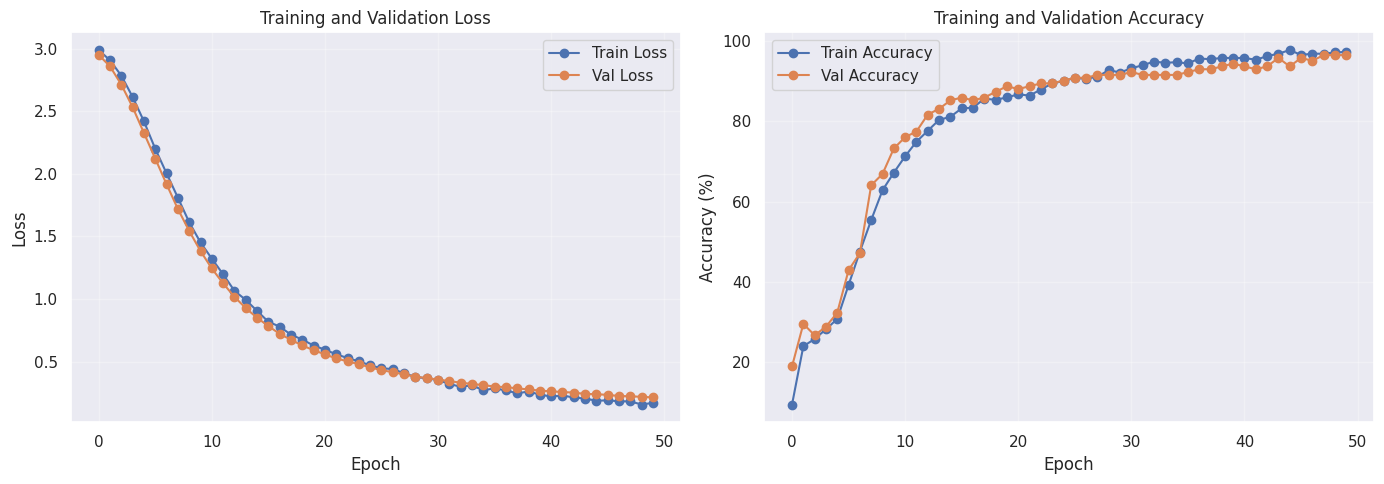

✓ Training curves saved to vit_training_curves.png


In [47]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Val Accuracy', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vit_training_curves.png', dpi=150)
plt.show()
print("✓ Training curves saved to vit_training_curves.png")

## Part 3: Evaluation

Evaluate the model on the test set with:
- Classification metrics (accuracy, precision, recall, F1)
- Confusion matrix
- Bounding box IoU
- Sample predictions visualization

In [48]:
# ==============================================================================
# PART 3: EVALUATION
# ==============================================================================

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

def evaluate_on_test(model, loader, device):
    """Evaluate model on test set and return predictions."""
    model.eval()
    all_preds = []
    all_labels = []
    all_bbox_preds = []
    all_bbox_true = []
    
    with torch.no_grad():
        for images, labels, bboxes in tqdm(loader, desc="Evaluating"):
            images = images.to(device)
            
            # Forward pass
            class_logits, bbox_pred = model(images)
            
            _, predicted = class_logits.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_bbox_preds.extend(bbox_pred.cpu().numpy())
            all_bbox_true.extend(bboxes.numpy())
    
    return (
        np.array(all_preds), 
        np.array(all_labels),
        np.array(all_bbox_preds),
        np.array(all_bbox_true)
    )

# Get predictions on test set
print("Evaluating on test set...")
test_preds, test_labels, test_bbox_preds, test_bbox_true = evaluate_on_test(model, test_loader, device)

# Classification accuracy
test_accuracy = accuracy_score(test_labels, test_preds)
print(f"\n✓ Test Accuracy: {test_accuracy*100:.2f}%")

Evaluating on test set...


Evaluating: 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


✓ Test Accuracy: 97.18%


### Classification Report

In [49]:
# Classification report
print("Classification Report:")
print("=" * 60)
print(classification_report(
    test_labels, 
    test_preds, 
    target_names=label_encoder.classes_,
    zero_division=0
))

Classification Report:
                   precision    recall  f1-score   support

           Agouti       1.00      1.00      1.00        13
        Bird_spec       1.00      1.00      1.00         4
    Coiban_Agouti       1.00      1.00      1.00         4
 Collared_Peccary       0.93      1.00      0.96        13
   Common_Opossum       1.00      1.00      1.00         6
    European_Hare       1.00      0.75      0.86         4
    Great_Tinamou       1.00      1.00      1.00         6
          Mouflon       1.00      1.00      1.00         7
           Ocelot       0.91      1.00      0.95        10
             Paca       1.00      0.88      0.93         8
         Red_Deer       0.95      1.00      0.98        20
          Red_Fox       0.80      1.00      0.89         4
     Red_Squirrel       1.00      1.00      1.00         6
         Roe_Deer       1.00      1.00      1.00         7
        Spiny_Rat       1.00      0.80      0.89         5
White-nosed_Coati       1.00    

### Visualize Predictions

Let's visualize some predictions with bounding boxes.

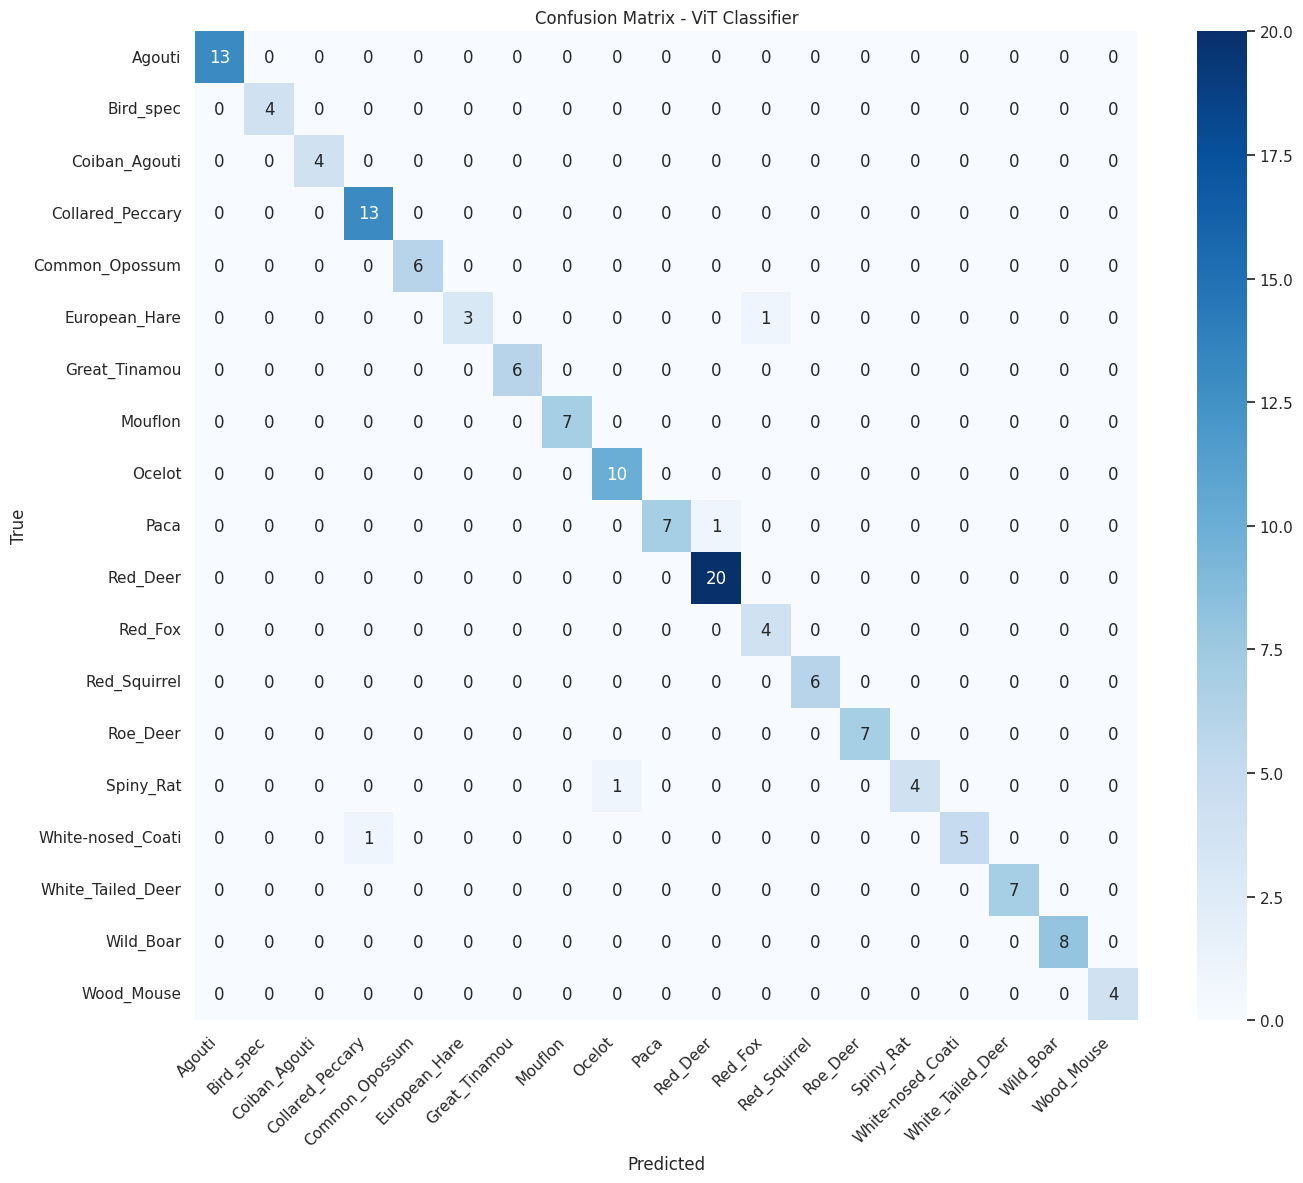

✓ Confusion matrix saved to vit_confusion_matrix.png


In [50]:
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - ViT Classifier')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('vit_confusion_matrix.png', dpi=150)
plt.show()
print("✓ Confusion matrix saved to vit_confusion_matrix.png")

### Bounding Box IoU Evaluation

Bounding Box Evaluation:
Mean IoU: 0.2416
Median IoU: 0.1839
IoU > 0.5: 19.7%
IoU > 0.75: 2.1%


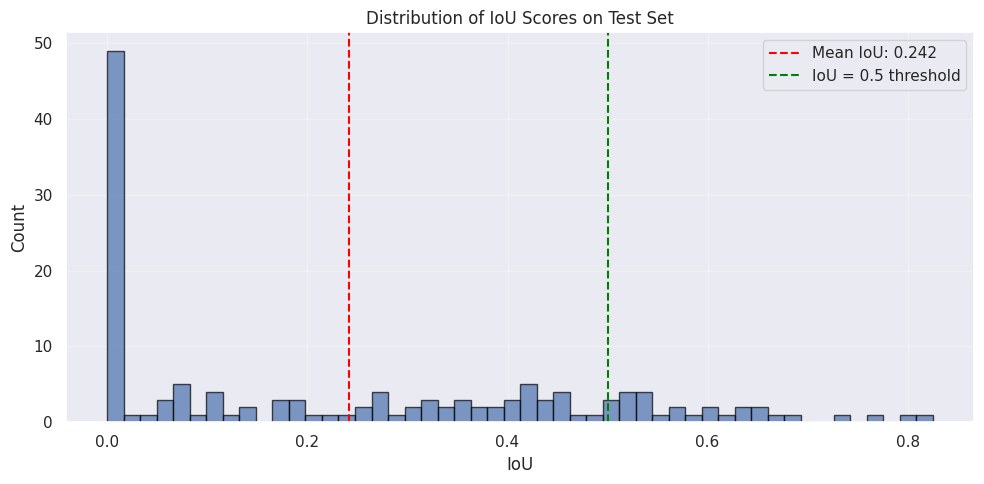

✓ IoU distribution saved to vit_iou_distribution.png


In [51]:
def compute_iou(box1, box2):
    """Compute IoU between two bounding boxes (x1, y1, x2, y2 format)."""
    # Get intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    
    # Get union
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0

# Compute IoU for all test samples
ious = [compute_iou(pred, true) for pred, true in zip(test_bbox_preds, test_bbox_true)]

mean_iou = np.mean(ious)
median_iou = np.median(ious)

print("Bounding Box Evaluation:")
print("=" * 60)
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Median IoU: {median_iou:.4f}")
print(f"IoU > 0.5: {np.mean(np.array(ious) > 0.5)*100:.1f}%")
print(f"IoU > 0.75: {np.mean(np.array(ious) > 0.75)*100:.1f}%")

# IoU distribution
plt.figure(figsize=(10, 5))
plt.hist(ious, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(mean_iou, color='red', linestyle='--', label=f'Mean IoU: {mean_iou:.3f}')
plt.axvline(0.5, color='green', linestyle='--', label='IoU = 0.5 threshold')
plt.xlabel('IoU')
plt.ylabel('Count')
plt.title('Distribution of IoU Scores on Test Set')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('vit_iou_distribution.png', dpi=150)
plt.show()
print("✓ IoU distribution saved to vit_iou_distribution.png")

### Sample Predictions Visualization

Visualize predictions with bounding boxes on test images.

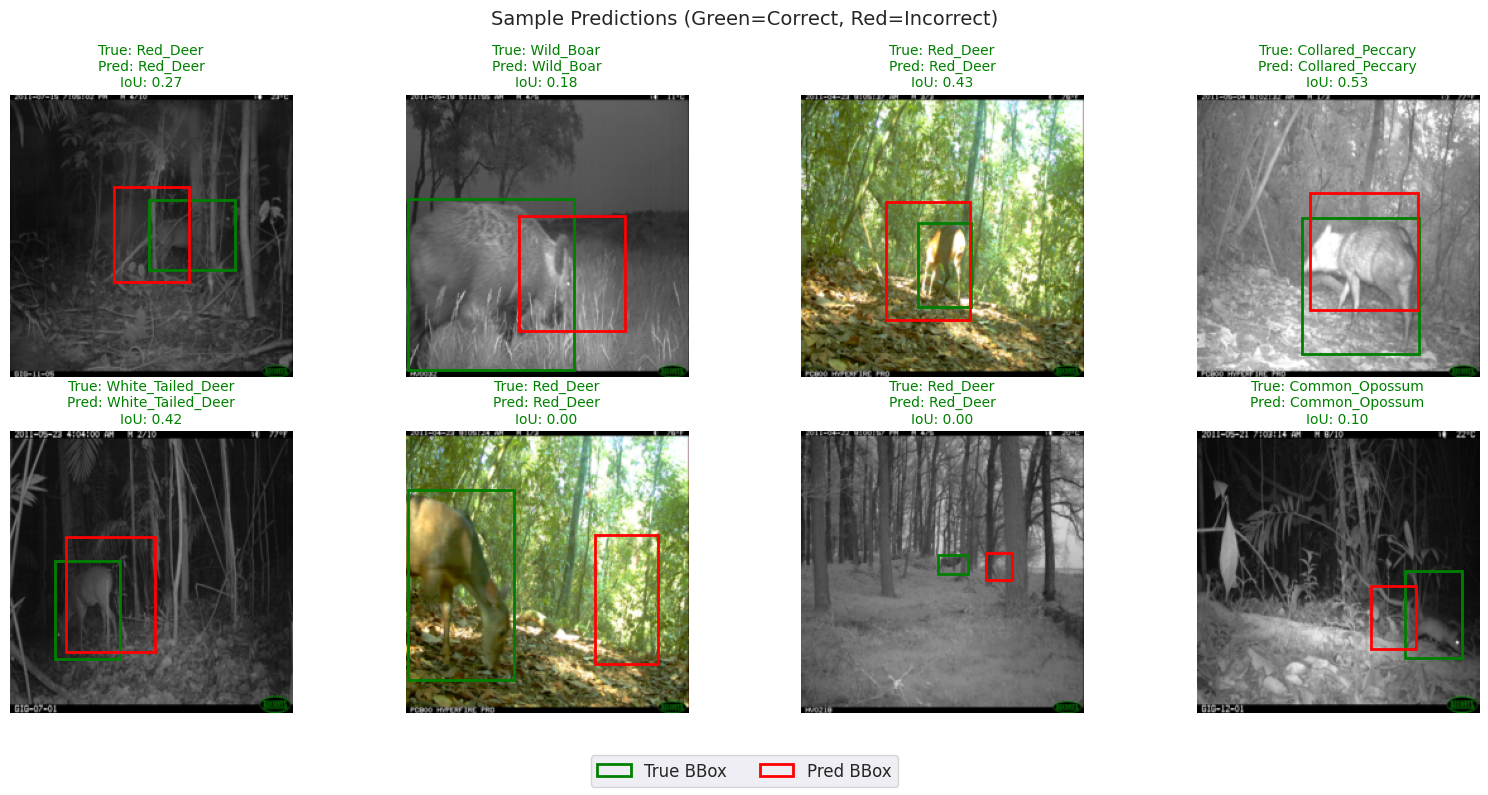

✓ Sample predictions saved to vit_sample_predictions.png


In [52]:
def visualize_predictions(model, dataset, indices, device, label_encoder):
    """Visualize predictions with bounding boxes."""
    model.eval()
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    # Unnormalize transform
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    for i, idx in enumerate(indices):
        if i >= 8:
            break
            
        img_tensor, true_label, true_bbox = dataset[idx]
        
        # Get prediction
        with torch.no_grad():
            img_batch = img_tensor.unsqueeze(0).to(device)
            class_logits, bbox_pred = model(img_batch)
            pred_class = class_logits.argmax(1).item()
            pred_bbox = bbox_pred.squeeze().cpu().numpy()
        
        # Unnormalize image for display
        img_display = img_tensor * std + mean
        img_display = img_display.permute(1, 2, 0).numpy()
        img_display = np.clip(img_display, 0, 1)
        
        # Get image dimensions
        h, w = img_display.shape[:2]
        
        # Scale bboxes to image size (they're normalized 0-1)
        true_box_scaled = true_bbox.numpy() * np.array([w, h, w, h])
        pred_box_scaled = pred_bbox * np.array([w, h, w, h])
        
        # Plot
        axes[i].imshow(img_display)
        
        # True bbox (green)
        x1, y1, x2, y2 = true_box_scaled
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                             linewidth=2, edgecolor='green', facecolor='none')
        axes[i].add_patch(rect)
        
        # Predicted bbox (red)
        x1, y1, x2, y2 = pred_box_scaled
        rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                             linewidth=2, edgecolor='red', facecolor='none')
        axes[i].add_patch(rect)
        
        # Get class names
        true_name = label_encoder.classes_[true_label.item()]
        pred_name = label_encoder.classes_[pred_class]
        
        # Compute IoU for this sample
        iou = compute_iou(pred_bbox, true_bbox.numpy())
        
        # Color title based on correctness
        color = 'green' if pred_class == true_label.item() else 'red'
        axes[i].set_title(f"True: {true_name}\nPred: {pred_name}\nIoU: {iou:.2f}", 
                         fontsize=10, color=color)
        axes[i].axis('off')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='none', edgecolor='green', linewidth=2, label='True BBox'),
        Patch(facecolor='none', edgecolor='red', linewidth=2, label='Pred BBox')
    ]
    fig.legend(handles=legend_elements, loc='lower center', ncol=2, fontsize=12)
    
    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.savefig('vit_sample_predictions.png', dpi=150)
    plt.show()
    print("✓ Sample predictions saved to vit_sample_predictions.png")

# Visualize random test samples
np.random.seed(42)
sample_indices = np.random.choice(len(test_dataset), 8, replace=False)
visualize_predictions(model, test_dataset, sample_indices, device, label_encoder)

### Final Summary

In [53]:
print("=" * 60)
print("ViT DETECTOR - FINAL RESULTS SUMMARY")
print("=" * 60)
print(f"\nDataset:")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Test samples: {len(test_dataset)}")
print(f"  Number of classes: {NUM_CLASSES}")

print(f"\nModel:")
print(f"  Architecture: ViT-Base-Patch16-224")
print(f"  Backbone: Frozen (transfer learning)")
print(f"  Trainable parameters: {trainable_params:,}")

print(f"\nTest Set Performance:")
print(f"  Classification Accuracy: {test_accuracy*100:.2f}%")
print(f"  Mean IoU: {mean_iou:.4f}")
print(f"  IoU > 0.5: {np.mean(np.array(ious) > 0.5)*100:.1f}%")

print(f"\nSaved Files:")
print(f"  ✓ vit_best_model.pt (model weights)")
print(f"  ✓ vit_training_curves.png")
print(f"  ✓ vit_confusion_matrix.png")
print(f"  ✓ vit_iou_distribution.png")
print(f"  ✓ vit_sample_predictions.png")
print("=" * 60)

ViT DETECTOR - FINAL RESULTS SUMMARY

Dataset:
  Training samples: 662
  Validation samples: 142
  Test samples: 142
  Number of classes: 19

Model:
  Architecture: ViT-Base-Patch16-224
  Backbone: Frozen (transfer learning)
  Trainable parameters: 462,487

Test Set Performance:
  Classification Accuracy: 97.18%
  Mean IoU: 0.2416
  IoU > 0.5: 19.7%

Saved Files:
  ✓ vit_best_model.pt (model weights)
  ✓ vit_training_curves.png
  ✓ vit_confusion_matrix.png
  ✓ vit_iou_distribution.png
  ✓ vit_sample_predictions.png
